<a href="https://colab.research.google.com/github/maniceet/How-do-you-like-them-Apples/blob/master/How_do_you_like_them_apples_(Model_Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Packages
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import re, string, unicodedata
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from functools import reduce
from fastai.text import *
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#Defining class to read txt file by paragraphs rather than by line
class ByParagraph:


    def __init__(self, text):
        self.text = text


    def __iter__(self):
        return self
        par = ""


    def __next__(self):
        par = []
        for line in self.text:
            if line.isspace():
                break
            par.append(line.strip())
        else:
            if not par:
                raise StopIteration()
        return ' '.join(par)


In [0]:
# Adding all paragraphs to a list for apple computers txt
apple_computers = []
with open('apple-computers.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_computers.append(par)

In [0]:
# Adding all paragraphs to a list for apple fruit txt
apple_fruits = []
with open('apple-fruit.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_fruits.append(par)

In [0]:
#Creating Training Data Frame
label = ['computer-company']*21 + ['fruit']*21
text = apple_computers + apple_fruits

df = pd.DataFrame(list(zip(text, label)), columns=['text', 'label'])


In [6]:
df.head()

,text,label
0,"Apple Inc. From Wikipedia, the free encycloped...",computer-company
1,"The Apple I, Apple's first product, was sold a...",computer-company
2,"Apple's ""1984"" television ad, set in a dystopi...",computer-company
3,"The first Macintosh, released in 1984 In 1984,...",computer-company
4,"The Macintosh Portable was Apple's first ""port...",computer-company


Paragraph Length: 
Mean 2456.05 words (median - 2031.500000)


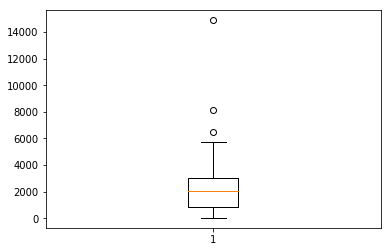

In [7]:
# Summarize Paragraph length
print("Paragraph Length: ")
result = [len(text) for text in df.text]
print("Mean %.2f words (median - %f)" % (np.mean(result), np.median(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [0]:
#Cleaning Training Data

#Remove HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
r_html = lambda x: strip_html_tags(x)

#Remove accented characters

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

r_accented = lambda x: remove_accented_chars(x)

#Expand Contractions

from contraction import expand_contractions
expand = lambda x: expand_contractions(x)


#Remove special characters

def remove_special_characters(text, remove_digits=False):
    #text = text.lower()
    text = re.sub('\w*\d\w*', '', text) #Removing words that have numbers in them
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[''""..._]' #Removing punctuations and underscores
    text = re.sub(pattern, '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)   #Removing characters that appear more than twice
    text = re.sub(r'\[', "",text)
    text = re.sub(r'\]', "",text)
    text = text.replace('\t', ' ')
    return text

In [0]:
functions = [strip_html_tags, remove_accented_chars, expand_contractions, remove_special_characters]

for fun in functions:
    df['text'] = df['text'].apply(fun)

In [0]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'])

In [15]:
train_df.head()

,text,label
25,Wild Malus sieversii apple in Kazakhstan The c...,fruit
38,Different kinds of apple cultivars in a superm...,fruit
26,Main article Apple symbolism,fruit
14,The current generation Apple TV At the Macwor...,computer-company
7,The MacBook Pro Apples first laptop with an In...,computer-company


In [16]:
valid_df.head()

,text,label
18,Company headquarters on Infinite Loop in Cuper...,computer-company
35,Leaves with significant insect damage Main art...,fruit
20,Portal icon San Francisco Bay Area portal Port...,computer-company
0,Apple Inc From Wikipedia the free encyclopedia...,computer-company
22,A typical apple Scientific classification King...,fruit


In [0]:
path = os.getcwd()

In [0]:
bs = 16
# Language model data
data_lm = TextLMDataBunch.from_df(path = os.getcwd(),train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label')

data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [51]:
data_lm.show_batch()

idx,text
0,he brought back to xxmaj xxunk xxunk have been the xxunk of xxunk xxunk xxunk xxmaj winter apples xxunk in late autumn and stored just xxunk xxunk have been an important food in xxmaj asia and xxmaj europe for xxunk xxmaj apples were brought to xxmaj north xxmaj america by xxunk in the century and the first apple xxunk on the xxmaj north xxmaj american continent was planted in xxmaj
1,and xxmaj xxunk a xxmaj storage xxmaj area xxmaj network xxunk system xxmaj for the professional xxunk market there is xxmaj xxunk for professional xxunk xxunk processing xxmaj final xxmaj cut xxmaj pro a video production suite xxmaj logic xxmaj pro a xxunk music xxunk and xxmaj motion an advanced effects xxunk program xxmaj apple also offers online services with icloud which xxunk xxunk storage and syncing for a wide
2,on average with xxmaj jobs speculating that the xxmaj app xxmaj store could become a xxunk business for xxmaj apple xxmaj three months later it was announced that xxmaj apple had become the xxunk mobile xxunk xxunk in the world due to the popularity of the iphone xxmaj on xxmaj december xxmaj apple announced that after over years of attending xxmaj macworld would be the last year xxmaj apple would
3,xxunk cancer and xxunk cancer xxmaj apple peels contain xxunk acid which in xxunk studies xxunk xxunk xxunk and brown fat and xxunk white fat xxunk xxunk xxunk and xxunk xxunk disease xxmaj according to the xxmaj united xxmaj states xxmaj xxunk of xxmaj xxunk a xxunk apple xxunk xxunk xxunk and xxunk xxunk with significant dietary fiber and vitamin c content xxmaj apple peels are a source of various
4,xxunk xxmaj google xxmaj maps that has xxunk some criticism xxmaj it was made available on xxmaj september and became xxmaj apples biggest iphone launch with over million xxunk xxunk back the xxunk date to late xxmaj october xxmaj on xxmaj october xxmaj apple unveiled the ipad xxmaj mini which features a inch screen in xxunk to the ipads inch screen xxmaj apple also released a thirdgeneration inch macbook xxmaj


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


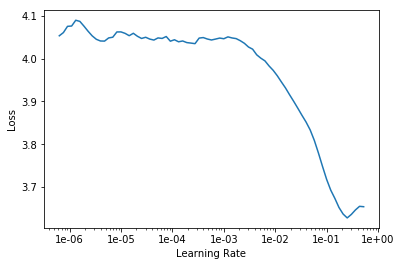

In [55]:
learn.recorder.plot(skip_end=15)

In [56]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.910485,3.280107,0.338929,00:00


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [60]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.408259,3.114202,0.359107,00:01
1,3.147793,3.520381,0.277321,00:01
2,2.811344,3.619725,0.288750,00:01
3,2.403381,4.075854,0.239107,00:01
4,1.946468,4.125576,0.279464,00:01
5,1.534389,4.184749,0.275000,00:01
6,1.183887,4.145274,0.269107,00:01
7,0.917964,4.068806,0.275000,00:01
8,0.722146,4.050701,0.280536,00:01
9,0.574697,4.057447,0.277500,00:01


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Steve jobs was "
N_WORDS = 40
N_SENTENCES = 2

In [66]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Steve jobs was  a raw Apple He was replaced by Tim Cook and Jobs became Apples chairman Prior to this Apple did not have a chairman and instead had two partners Tim
Steve jobs was  found in the early The Apple Lisa On April Apple introduced their Macintosh Newton was the first Apple II the first and first American Red White to


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = os.getcwd(), train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label', bs=16)

In [86]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj apple store in xxmaj xxunk xxmaj new xxmaj york xxmaj on xxmaj january xxmaj jobs announced in an internal xxmaj apple memo that he would take another xxunk leave of absence for an xxunk period to allow him to focus on his health xxmaj xxunk operating xxunk xxmaj tim xxmaj cook xxunk xxmaj jobs xxunk operations at xxmaj apple although xxmaj jobs would still xxunk xxunk in major,computer-company
xxbos xxmaj the macbook xxmaj pro xxmaj apples first laptop with an xxmaj intel xxunk announced in xxmaj january xxmaj at the xxmaj worldwide xxmaj developers xxmaj conference keynote xxunk on xxmaj june xxmaj steve xxmaj jobs announced that xxmaj apple would xxunk producing xxmaj xxunk xxmaj mac computers in xxmaj on xxmaj january the new macbook xxmaj pro and imac became the first xxmaj apple computers to use xxmaj,computer-company
xxbos xxmaj the original iphone and to xxunk xxmaj main article iphone xxmaj at the xxmaj macworld xxmaj conference xxmaj expo in xxmaj january xxmaj steve xxmaj jobs introduced the xxunk iphone a xxunk of an xxmaj xxunk smartphone and ipod xxmaj the original iphone was released on xxmaj june for xxup gb and xxup gb with an xxup att contract xxmaj on xxmaj february it was updated to have,computer-company
xxbos xxmaj the current generation xxmaj apple xxup tv xxmaj at the xxmaj macworld conference xxmaj jobs xxunk the xxmaj apple xxup tv xxunk known as the xxunk a xxunk video device xxunk to xxunk the sale of content from itunes with xxunk xxunk xxmaj the device links up to a users xxup tv and xxunk either via wifi or a xxunk network with one computers itunes library and xxunk,computer-company
xxbos xxmaj logo xxmaj see also xxunk and xxmaj xxunk of xxmaj apple xxmaj inc xxmaj apple logo redirects here xxmaj for the programming language see xxmaj apple xxmaj logo xxmaj according to xxmaj steve xxmaj jobs xxmaj apple was so named because xxmaj jobs was xxunk back from an apple xxunk and he was on a xxunk diet xxmaj he thought the name was xxunk xxunk and not xxunk,computer-company


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [88]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


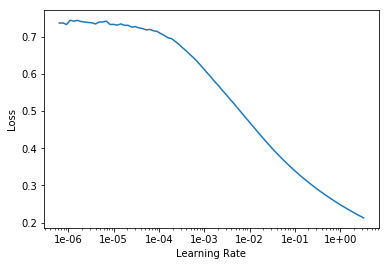

In [89]:
learn.recorder.plot()

In [90]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.699461,0.728841,0.444444,00:02


In [0]:
learn.save('first')


In [0]:
learn.load('first');

In [93]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.261144,0.688750,0.555556,00:02


In [0]:
learn.save('second')


In [0]:
learn.load('second');

In [100]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.241552,0.571218,0.888889,00:02


In [0]:
learn.save('third')


In [0]:
learn.load('third');

In [111]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.144413,0.484181,0.888889,00:03
1,0.118034,0.282354,1.000000,00:03
2,0.107671,0.255114,1.000000,00:03


In [0]:
learn.save('fine_tuned_classifier')

In [113]:
learn.predict("When Steve Jobs stepped down as Apple's CEO in August 2011, people said it was the end of an era. The departure of Apple design chief Jony Ive, announced Thursday, is the latest sign of the new Apple. \
For the past couple of decades, Apple has gone through one of the most dramatic resurgences in history. Its tale of dramatic rise under co-founder Jobs, its decline and near death after his ouster, and then its rebirth are the stuff of Silicon Valley legend")

(Category computer-company, tensor(0), tensor([0.7637, 0.2363]))

In [114]:
learn.predict('ve and Jobs were close friends, bonding over frequent lunches and a similar sensibility for design. "We on the first meeting, in a quite shocking way, really did click," Ive said in a rare interview in 2017. "We just established an immediate understanding."')

(Category fruit, tensor(1), tensor([0.4786, 0.5214]))

In [116]:
learn.predict('The departure of Ive, whose soft, British voice introduced Apple hardware in countless sizzle reels, is the latest sign of major shifts within Apple. The company grew to become one of the worlds most profitable and highly valued companies, worth nearly $1 trillion, on the back of the iPhone.')

(Category computer-company, tensor(0), tensor([0.6626, 0.3374]))